### the three blocks are the whole model

In [0]:
import numpy as np
import matplotlib.pyplot as pl
import math

class Activation(object):

      
    def __relu(self,x):
        
        return np.maximum(0,x)
      
    def __relu_deriv(self,a):
        a[a>0]=1
        a[a<=0]=0
        return a
      
    def __softmax(self, x):
        """
        x is of shape(m,n_in)
        """
        y= np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)
        assert(y.shape == x.shape)
        
        return y
      
    def __softmax_deriv(self, a):
        
        y = a*(1-a)
        assert(y.shape == a.shape)
        return y

    def __init__(self,activation='relu'):
        if activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

In [0]:
class HiddenLayer(object):    
    def __init__(self, n_in, n_out, W=None, b=None, activation = "relu" ):
        
        self.act = activation

        self.input=None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        np.random.seed(7)
        
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        
        self.b = np.zeros((1, n_out))
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.v_dW = np.zeros(self.W.shape)
        self.v_db = np.zeros(self.b.shape)
        
    def forward(self, input, keep_prob):
        '''
        :type input: numpy.array
        :input.shape = (m, n_in), b.shape = (1, n_out), W.shape = (n_in, n_out)
        :lin_output.shape = (m, n_out)
        '''

        lin_output = np.dot(input, self.W) + self.b
        
        assert(self.W.shape[1] == self.b.shape[1])
        assert(input.shape[1] == self.W.shape[0])
        assert(input.shape[0] == lin_output.shape[0])
        
        if self.act == "softmax":
            keep_prob = 1
  
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )

        output = np.atleast_2d(self.output)

        d = np.random.rand(output.shape[0],output.shape[1]) < keep_prob
        output = np.multiply(d, output)
        output /= keep_prob
        
        assert(output.shape == self.output.shape)

        self.input=input
        self.output = output
        return self.output
    
    def backward(self, delta, beta, keep_prob):       
        """
        :self.input.shape = (m, n_in)
        :delta.shape = (m, n_out)
        :self.grad_W.shape = (n_in, n_out)
        :self.grad_b.shape = (1, n_out)
        :delta_.shape = (m, n_in)
        """
        delta = np.atleast_2d(delta)
        self.input = np.atleast_2d(self.input)
        assert(self.input.shape[0] == delta.shape[0])
        m = self.input.shape[0]
        
        self.grad_W = self.input.T.dot(delta)/m
        self.grad_b = np.sum(delta, axis = 0)/m
        
        self.grad_b = np.atleast_2d(self.grad_b)
        

        self.v_dW = beta * self.v_dW + (1-beta) * self.grad_W
        self.v_db = beta * self.v_db + (1-beta) * self.grad_b

        assert(self.v_dW.shape == self.grad_W.shape)
        assert(self.v_db.shape == self.grad_b.shape)
        
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        delta_ /= keep_prob
        assert(delta_.shape == self.input.shape)
        return delta_

In [0]:
class MLP:
    """
    """      
    def __init__(self, layers):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values

        """        
        ### initialize layers

        self.layers=[]
        self.layers_number = layers
        self.params=[]

        self.activation= None 
        
        for i in range(len(layers)-2):
            self.layers.append(HiddenLayer(layers[i],layers[i+1], activation="relu"))

        L = len(layers)
        self.layers.append(HiddenLayer(layers[L-2],layers[L-1], activation="softmax"))
            
    def forward(self, input, keep_prob):
        for layer in self.layers:
            output=layer.forward(input, keep_prob)
            input=output
        
        return output
    
    def criterion_cross_entropy(self, y, y_hat):
        """
        y.shape = y-hat.shape = (m, yn)
        delta.shape = (m, yn)
        """
      
        assert(y.shape == y_hat.shape)
        
        activation_deriv=Activation("softmax").f_deriv
        
        loss = -np.sum(np.log(y_hat) * y) 
                
        error = y-y_hat
        
        delta = error*activation_deriv(y_hat)  
        assert(delta.shape == y.shape)
        return loss, delta
      
    
    def backward(self,delta, beta, keep_prob):        
        for layer in reversed(self.layers):
            delta=layer.backward(delta, beta, keep_prob)
            
    def update(self,lr):
        """
        v_db.shape = (m, n_out)
        b.shape = (1, n_out)
        """
        for layer in self.layers:
            layer.W += lr * layer.v_dW                   
            layer.b += lr * layer.v_db
            
   
    def create_mini_batch(self, mini_batch_size, labels, X, y, yn, num_features, m):
        """
        
        """
        #initializations
        np.random.seed(1)

        mini_batches = []            
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_y = y[permutation, :]
        
        labels = labels[permutation]
        mini_batches_labels = labels

        num_com_batches = math.floor(m/mini_batch_size)
        
        for k in range(0, num_com_batches):
            mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch_y = shuffled_y[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            assert(mini_batch_X.shape == (mini_batch_size, num_features))
            assert(mini_batch_y.shape == (mini_batch_size, yn))
            
        if m % mini_batch_size !=0: 
            mini_batch_X = shuffled_X[(k+1)*mini_batch_size:, : ]
            mini_batch_y = shuffled_y[(k+1)*mini_batch_size:, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            
        return mini_batches, mini_batches_labels
      
    def fit_pre_processing(self, X, labels, epochs):
      
        labels = labels.flatten()
        assert(X.shape[0] == labels.shape[0])

        y = (np.arange(self.layers_number[-1]) == labels[:, None]).astype(float)
        yn = y.shape[1]
        assert(y.shape[0] == X.shape[0])
                
        num_features = X.shape[1]       
        m = X.shape[0]
        
        to_return_cost = np.zeros(epochs)
        to_return_accuracy = np.zeros(epochs)
        
        return y, yn, num_features, m, to_return_cost, to_return_accuracy
      
    def fit(self, X, labels, learning_rate=0.1, epochs=100, keep_prob = 1, beta=0, mini_batch_size = 1, X_test = None, labels_test = None, ):
        
        """
        :X.shape = (m, num_features)
        :labels.shape = (m, 1) / (m,)
        :y.shape = (m, yn)
        :y_hat.shape = y.shape
        """
        y, yn, num_features, m, to_return_cost, to_return_accuracy = self.fit_pre_processing(X, labels, epochs)
        
        if X_test and labels_test:
            y_test, yn_test, num_features_test, m_test, to_return_cost_test, to_return_accuracy_test = self.fit_pre_processing(X_test, labels_test, epochs)

            assert(num_features == num_features_test)
            assert(yn == yn_test)

            num_features_test = num_features
            yn_test = yn

        mini_batches, mini_batches_labels = self.create_mini_batch(mini_batch_size, labels, X, y, yn, num_features, m)

        for k in range(epochs):
            y_hat_labels = []

            for mini_batch in mini_batches:
                
                mini_batch_X, mini_batch_y = mini_batch
                
                mini_batch_y_hat = self.forward(mini_batch_X, keep_prob)
                
                loss, delta=self.criterion_cross_entropy(mini_batch_y, mini_batch_y_hat)
                
                self.backward(delta, beta, keep_prob)
                
                self.update(learning_rate)
                
                y_hat_label = mini_batch_y_hat.argmax(axis = 1)
                
                y_hat_labels = np.append(y_hat_labels, y_hat_label)
    
            to_return_cost[k] = np.mean(loss)
            
            assert(len(y_hat_labels) == len(mini_batches_labels))
            to_return_accuracy[k] = str(np.sum((y_hat_labels == mini_batches_labels)/m)) 
            
            if X_test and labels_test:
              
                y_hat_test = self.forward(X_test, keep_prob = 1)
                
                loss_test, delta_test=self.criterion_cross_entropy(y_test, y_hat_test)
                
                y_hat_label_test = y_hat_test.argmax(axis = 1)
                
                assert(len(y_hat_label_test) == len(labels_test))
                
                to_return_cost_test[k] = np.mean(loss_test)
                
                to_return_accuracy_test[k] = str(np.sum((y_hat_label_test == labels_test)/m_test))
            
            if k % 10000 ==0:
                print("Cost after iteration %i: %f" %(k, to_return_cost[k]))
                print("Accuracy after iteration %i: %f" %(k, to_return_accuracy[k]))

        print("accuracy: ", to_return_accuracy[k])
        print("cost: ", to_return_cost[k])
        if X_test and labels_test: 
            print("accuracy_test: ", to_return_accuracy_test[k])
            print("cost_test: ", to_return_cost_test[k])
        
        if X_test and labels_test:
            return to_return_cost, to_return_accuracy, to_return_cost_test, to_return_accuracy_test, y_hat_label_test        
        else:
            return to_return_cost, to_return_accuracy


### This MLP_train altomatically trains the training data. just need to input number of inputs: m and other parameters.

In [0]:

class MLP_train():
    """
    hidden layers - a python list
    """
    def __init__(self, m, num_features = 128, yn = 10):
        
        
          
        self.m = m
        self.num_features = num_features
        self.yn = yn

        self.X_train = X[0:m,:]
        self.labels_train = labels[0:m]
   
    def cal(self, mini_batch_size = 1, beta = .8, keep_prob = 1, learning_rate = .005, epochs = 100, hidden_layers = None):
        
        m = self.m
        num_features = self.num_features
        yn = self.yn
        
        if mini_batch_size > m: 
          raise ValueError('mini_batch_size too big')
         
        if hidden_layers == None:
            layers_number = [num_features, yn]
        else:
            layers_number = [num_features] + hidden_layers + [yn]
          
        case = MLP(layers_number)
        cost, accuracy = case.fit(self.X_train, self.labels_train, learning_rate, epochs, keep_prob, beta, mini_batch_size, X_test = None, labels_test= None)

        %matplotlib inline
        
        pl.plot(cost)
        pl.plot(accuracy)
        

    

### input data from local

In [44]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_128.h5 to train_128.h5
Saving train_label.h5 to train_label.h5
User uploaded file "train_128.h5" with length 61442144 bytes
User uploaded file "train_label.h5" with length 482144 bytes


### load in data

In [0]:

import numpy as np
with h5py.File('train_128.h5','r') as H:
    X = np.copy(H['data'])

with h5py.File('train_label.h5','r') as H:
    labels = np.copy(H['label'])

### normalise data: using z_score or normalisation method

In [0]:
def z_score(x, axis):
    x = np.array(x).astype(float)
    xr = np.rollaxis(x, axis=axis)
    xr -= np.mean(x, axis=axis)
    xr /= np.std(x, axis=axis)
    # print(x)
    return x
  


In [0]:
"""
needs to be debugged
"""
def norm(x, axis):
    x = np.array(x).astype(float)
    x_mean = np.mean(x, axis = axis)
    x_max = np.max(x, axis = axis)
    x_min = np.min(x, axis = axis)
    x_ = (x-np.atleast_2d(x_mean))/(x_max-x_min)

    # print(x)
    return x

In [126]:
"""
for testing 
"""
x = np.array([[1,2,3],
             [2,5,6]])
z_score(x,1)
norm(x,0)

array([[1., 2., 3.],
       [2., 5., 6.]])

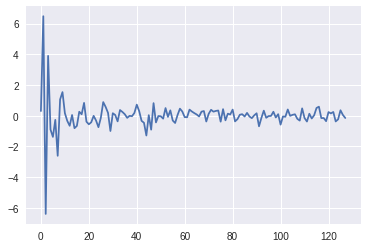

In [124]:
"""
for testing normalization methods on X
"""
X_norm = z_score(X, 1)
pl.plot(X_norm[800])

### train the training data

Cost after iteration 0: nan
Accuracy after iteration 0: 0.000000
accuracy:  0.0
cost:  386.382842515974


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


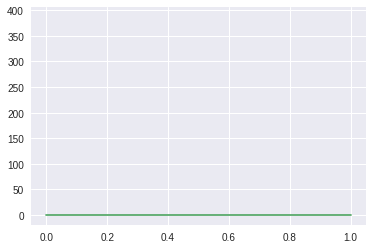

In [125]:
"""
- the X_train is the data to be trained - can be itself, i.e. X_train, or X_norm, etc.
- in test_1 = MLP_train(m= ). the m needs to be specified
- in test_1.cal, parameters need to be specified
- when encountered with runtime warning, it means either the normalization of X is not enough or learning rate is not appropriate
"""
X_train = X_norm
test_1 = MLP_train(m=10)
test_1.cal(mini_batch_size = 10, beta = .8, keep_prob = 1, learning_rate = .005, epochs = 2, hidden_layers = [5])

In [0]:
#@title
test = MLP_train_random(m=100, num_features = 5, yn = 4)
test.cal(mini_batch_size = 100, beta = 0.8, keep_prob = 1, learning_rate = 0.08, epochs = 500000, hidden_layers = [2])

In [0]:
#@title

class MLP_train_random():
    """
    hidden layers - a python list
    """
    def __init__(self, m, num_features, yn):
        
        
          
        self.m = m
        self.num_features = num_features
        self.yn = yn
        np.random.seed(1)
        self.X_train = np.random.randint(num_features, size = (m, num_features))
        self.labels_train = np.random.randint(yn, size = (m))
    def cal(self, mini_batch_size = 1, beta = .8, keep_prob = 1, learning_rate = .005, epochs = 100, hidden_layers = None):
      
        m = self.m
        num_features = self.num_features
        yn = self.yn
        
        if mini_batch_size > m: 
          raise ValueError('mini_batch_size too big')
         
        if hidden_layers == None:
            layers_number = [num_features, yn]
        else:
            layers_number = [num_features] + hidden_layers + [yn]
          
        case = MLP(layers_number)
        cost, accuracy = case.fit(self.X_train, self.labels_train, learning_rate, epochs, keep_prob, beta, mini_batch_size, X_test = None, labels_test= None)

        %matplotlib inline
        
        pl.plot(cost)
        pl.plot(accuracy)
  

### full printing model: below code is just the above code with printing funcitons: intended for testing: it can overwrite the first three blocks

In [0]:
import numpy as np
import matplotlib.pyplot as pl
import math

class Activation(object):

      
    def __relu(self,x):
        
        return np.maximum(0,x)
      
    def __relu_deriv(self,a):
        a[a>0]=1
        a[a<=0]=0
        return a
      
    def __softmax(self, x):
        """
        x is of shape(m,n_in)
        """
        y= np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)
        assert(y.shape == x.shape)
        
        return y
      
    def __softmax_deriv(self, a):
        
        y = a*(1-a)
        assert(y.shape == a.shape)
        return y

    def __init__(self,activation='relu'):
        if activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
            
class HiddenLayer(object):    
    def __init__(self, n_in, n_out, W=None, b=None, activation = "relu" ):
        
        self.act = activation

        self.input=None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        np.random.seed(7)
        
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )

       
        self.b = np.zeros((1, n_out))
        
        print('1. initialized W: \n', self.W)
        print('2. initialzied b: \n', self.b)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.v_dW = np.zeros(self.W.shape)
        self.v_db = np.zeros(self.b.shape)
        
    def forward(self, input, keep_prob):
        '''
        :type input: numpy.array
        :input.shape = (m, n_in), b.shape = (1, n_out), W.shape = (n_in, n_out)
        :lin_output.shape = (m, n_out)
        '''

        lin_output = np.dot(input, self.W) + self.b
        
        print('forward 1. input: \n', input)
        print('forward 2. W: \n', self.W)
        print('forward 3. b: \n', self.b)
        print('forward 4, lin_output: \n', lin_output)
        
        assert(self.W.shape[1] == self.b.shape[1])
        assert(input.shape[1] == self.W.shape[0])
        assert(input.shape[0] == lin_output.shape[0])
        
        if self.act == "softmax":
            keep_prob = 1
  
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )

        output = np.atleast_2d(self.output)

        d = np.random.rand(output.shape[0],output.shape[1]) < keep_prob
        output = np.multiply(d, output)
        output /= keep_prob
        print('forward 5, act_output: \n', output)
        assert(output.shape == self.output.shape)

        self.input=input
        self.output = output
        return self.output
    
    def backward(self, delta, beta, keep_prob):       
        """
        :self.input.shape = (m, n_in)
        :delta.shape = (m, n_out)
        :self.grad_W.shape = (n_in, n_out)
        :self.grad_b.shape = (1, n_out)
        :delta_.shape = (m, n_in)
        """
        delta = np.atleast_2d(delta)
        self.input = np.atleast_2d(self.input)
        assert(self.input.shape[0] == delta.shape[0])
        m = self.input.shape[0]
        
        print('backward 1. delta_in : \n', delta)
        print('backward 2. input : \n', self.input)
        
        self.grad_W = self.input.T.dot(delta)/m
        self.grad_b = np.sum(delta, axis = 0)/m    
        self.grad_b = np.atleast_2d(self.grad_b)
        

        self.v_dW = beta * self.v_dW + (1-beta) * self.grad_W
        self.v_db = beta * self.v_db + (1-beta) * self.grad_b

        assert(self.v_dW.shape == self.grad_W.shape)
        assert(self.v_db.shape == self.grad_b.shape)
        
        print('backward 3. self.grad_W  : \n', self.grad_W )
        print('backward 4. self.grad_b : \n', self.grad_b)
        print('backward 5. self.v_dW : \n', self.v_dW)
        print('backward 6. self.v_db : \n', self.v_db)
        
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        delta_ /= keep_prob
        assert(delta_.shape == self.input.shape)
        
        print('backward 7. self.W.T : \n', self.W.T)
        print('backward 8. self.activation_deriv(self.input) : \n', self.activation_deriv(self.input))
        print('backward 9. delta_ : \n', delta_)
        
        return delta_

class MLP:
    """
    """      
    def __init__(self, layers):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values

        """        
        ### initialize layers

        self.layers=[]
        self.layers_number = layers
        self.params=[]

        self.activation= None 
        
        for i in range(len(layers)-2):
            print ('layer: ', i)
            self.layers.append(HiddenLayer(layers[i],layers[i+1], activation="relu"))

        L = len(layers)
        print ('layer: ', i)
        self.layers.append(HiddenLayer(layers[L-2],layers[L-1], activation="softmax"))
            
    def forward(self, input, keep_prob):
        for layer in self.layers:
            output=layer.forward(input, keep_prob)
            input=output
        
        return output
    
    def criterion_cross_entropy(self, y, y_hat):
        """
        y.shape = y-hat.shape = (m, yn)
        delta.shape = (m, yn)
        """
      
        assert(y.shape == y_hat.shape)
        
        activation_deriv=Activation("softmax").f_deriv
        
        loss = -np.sum(np.log(y_hat) * y) 
                
        error = y-y_hat
        
        delta = error*activation_deriv(y_hat)  
        
        print('criterion_cross_entropy 1. y: \n', y)
        print('criterion_cross_entropy 2. y_hat: \n', y_hat)
        print('criterion_cross_entropy 3. activation_deriv: \n', activation_deriv)
        print('criterion_cross_entropy 4. loss: \n', loss)
        print('criterion_cross_entropy 5. error: \n', error)
        print('criterion_cross_entropy 6. delta: \n', delta)
        
        
        assert(delta.shape == y.shape)
        return loss, delta
      
    
    def backward(self,delta, beta, keep_prob):        
        for layer in reversed(self.layers):
            delta=layer.backward(delta, beta, keep_prob)
            
    def update(self,lr):
        """
        v_db.shape = (m, n_out)
        b.shape = (1, n_out)
        """
        for layer in self.layers:
            print('update 1. layer.W: \n', layer.W)
            print('update 2. layer.b: \n', layer.b)
            layer.W += lr * layer.v_dW                   
            layer.b += lr * layer.v_db
            
            print('update 3. layer.v_dW : \n', layer.v_dW)
            print('update 4. layer.v_db: \n', layer.v_db)
            print('update 5. layer.W: \n', layer.W)
            print('update 6. layer.b: \n', layer.b)
            
   
    def create_mini_batch(self, mini_batch_size, labels, X, y, yn, num_features, m):
        """
        
        """
        #initializations
        np.random.seed(1)

        mini_batches = []            
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_y = y[permutation, :]
        
        labels = labels[permutation]
        mini_batches_labels = labels

        num_com_batches = math.floor(m/mini_batch_size)
        
        for k in range(0, num_com_batches):
            mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch_y = shuffled_y[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            assert(mini_batch_X.shape == (mini_batch_size, num_features))
            assert(mini_batch_y.shape == (mini_batch_size, yn))
            
        if m % mini_batch_size !=0: 
            mini_batch_X = shuffled_X[(k+1)*mini_batch_size:, : ]
            mini_batch_y = shuffled_y[(k+1)*mini_batch_size:, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            
        return mini_batches, mini_batches_labels
      
    def fit_pre_processing(self, X, labels, epochs):
      
        labels = labels.flatten()
        assert(X.shape[0] == labels.shape[0])

        y = (np.arange(self.layers_number[-1]) == labels[:, None]).astype(float)
        yn = y.shape[1]
        assert(y.shape[0] == X.shape[0])
                
        num_features = X.shape[1]       
        m = X.shape[0]
        
        to_return_cost = np.zeros(epochs)
        to_return_accuracy = np.zeros(epochs)
        
        return y, yn, num_features, m, to_return_cost, to_return_accuracy
      
    def fit(self, X, labels, learning_rate=0.1, epochs=100, keep_prob = 1, beta=0, mini_batch_size = 1, X_test = None, labels_test = None, ):
        
        """
        :X.shape = (m, num_features)
        :labels.shape = (m, 1) / (m,)
        :y.shape = (m, yn)
        :y_hat.shape = y.shape
        """
        y, yn, num_features, m, to_return_cost, to_return_accuracy = self.fit_pre_processing(X, labels, epochs)
        
        if X_test and labels_test:
            y_test, yn_test, num_features_test, m_test, to_return_cost_test, to_return_accuracy_test = self.fit_pre_processing(X_test, labels_test, epochs)

            assert(num_features == num_features_test)
            assert(yn == yn_test)

            num_features_test = num_features
            yn_test = yn

        mini_batches, mini_batches_labels = self.create_mini_batch(mini_batch_size, labels, X, y, yn, num_features, m)

        for k in range(epochs):
          
            print('epoch ', k, ':')
            y_hat_labels = []

            for mini_batch in mini_batches:
                
                mini_batch_X, mini_batch_y = mini_batch
                
                mini_batch_y_hat = self.forward(mini_batch_X, keep_prob)
                
                loss, delta=self.criterion_cross_entropy(mini_batch_y, mini_batch_y_hat)
                
                self.backward(delta, beta, keep_prob)
                
                self.update(learning_rate)
                
                y_hat_label = mini_batch_y_hat.argmax(axis = 1)
                
                y_hat_labels = np.append(y_hat_labels, y_hat_label)
    
            to_return_cost[k] = np.mean(loss)
            
            assert(len(y_hat_labels) == len(mini_batches_labels))
            to_return_accuracy[k] = str(np.sum((y_hat_labels == mini_batches_labels)/m)) 
            
            if X_test and labels_test:
              
                y_hat_test = self.forward(X_test, keep_prob = 1)
                
                loss_test, delta_test=self.criterion_cross_entropy(y_test, y_hat_test)
                
                y_hat_label_test = y_hat_test.argmax(axis = 1)
                
                assert(len(y_hat_label_test) == len(labels_test))
                
                to_return_cost_test[k] = np.mean(loss_test)
                
                to_return_accuracy_test[k] = str(np.sum((y_hat_label_test == labels_test)/m_test))
            
            if k % 100 ==0:
                print("Cost after iteration %i: %f" %(k, to_return_cost[k]))
                print("Accuracy after iteration %i: %f" %(k, to_return_accuracy[k]))

        print("accuracy: ", to_return_accuracy[k])
        print("cost: ", to_return_cost[k])
        if X_test and labels_test: 
            print("accuracy_test: ", to_return_accuracy_test[k])
            print("cost_test: ", to_return_cost_test[k])
        
        if X_test and labels_test:
            return to_return_cost, to_return_accuracy, to_return_cost_test, to_return_accuracy_test, y_hat_label_test        
        else:
            return to_return_cost, to_return_accuracy
